# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Цель исследования:**
1. Определить рыночную стоимость объектов недвижимости.
2. Построить атоматизированную систему, которая отследит аномалии и мошенническую деятельность.
3. Установить, какие факторы влияют на ценообразование стоимости квартир.

**Ход исследования:**
- обзор данных;
- предобработка данных;
- расчеты и добавление результатов в таблицу;
- проведение анализа для Ленинградской области;
- Проведение анализа для Санкт-Петербурга;
- Различаются ли факторы, которые влияют на ценообразование стоимости квартир;
- Общий вывод.

## Обзор данных

In [1]:
#импорт библиотек
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('./real_estate_data.csv', sep='\t')
data.info() 
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


- в данных содержатся пропуски;
- не все типы данных в столбцах соответсвтуют действительности.

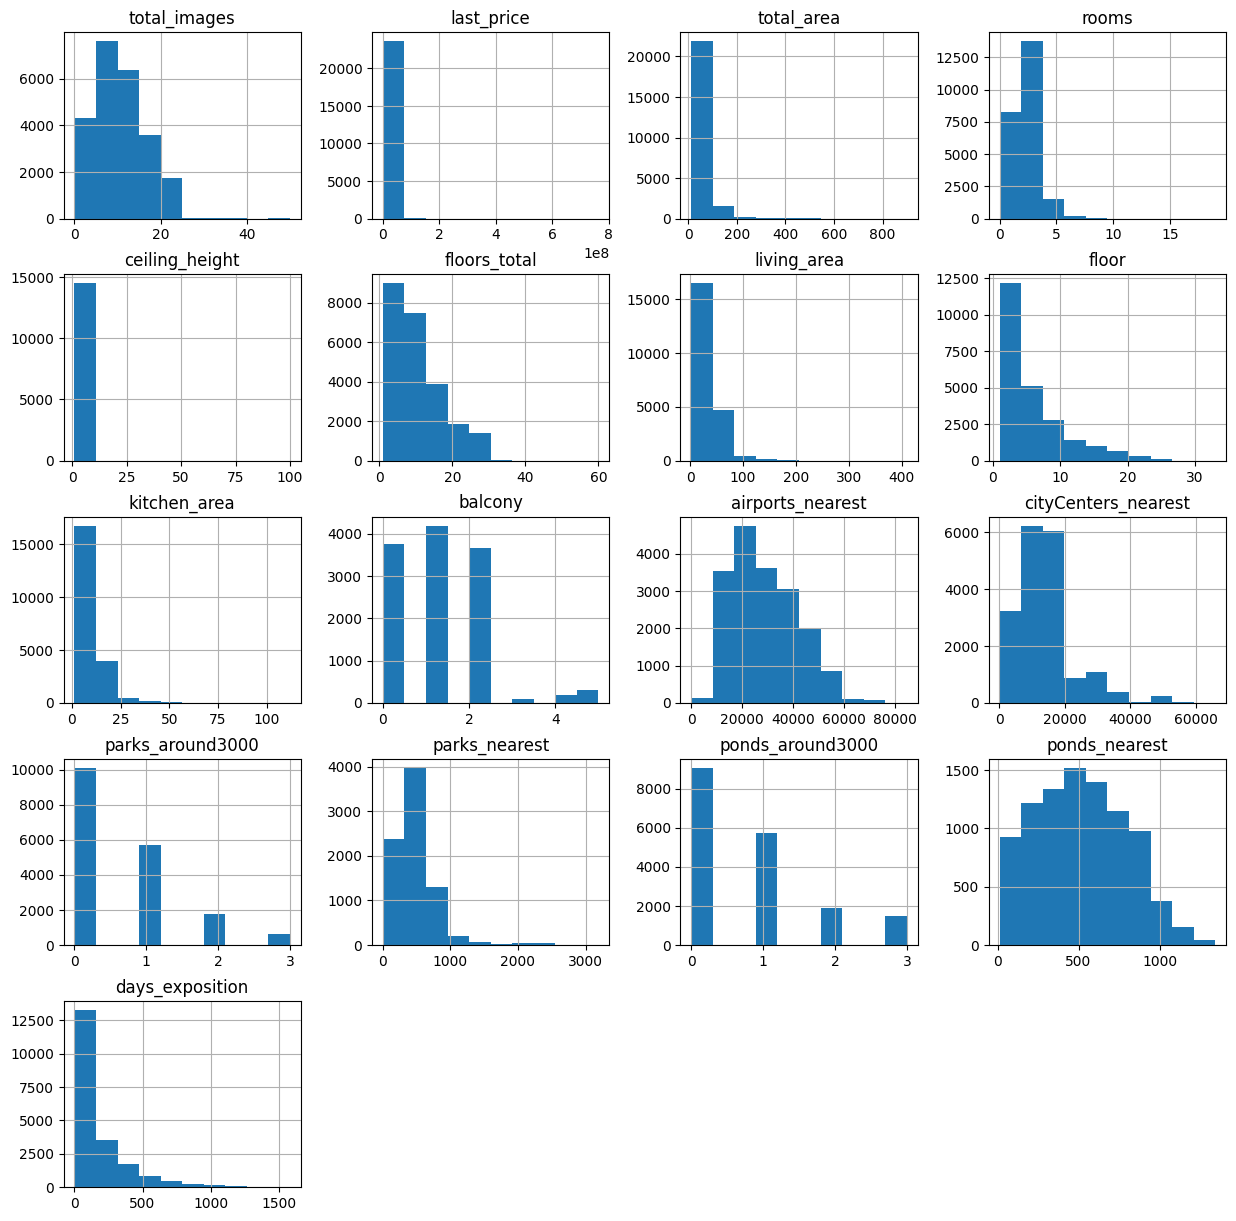

In [3]:
data.hist(figsize=(15, 15)); #вывод гистограмм для каждого числового столбца датафрейма 

В некоторых столбцах наблюдается странное распределение данных. Рассмотрим это поподробней далее.

## Предобработка данных

### Нахождение пропусков в данных

In [4]:
pd.DataFrame(round(data.isna().mean()*100, 2)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.360000
living_area,8.030000
floor,0.000000
is_apartment,88.290000


Пропуски в столбцах `floors_total`, `living_area`, `locality_name` можно не заполнять, поскольку процент этих от общего числа строк в датафрейме невелик и заполнять их каким-то медианным/средним значением не имеет смысла. Данные пропуски скорее всего появились из-за того, что эти данные просто не указали в объявлении.

Пропуски в столбце `is_apartment` можно заполнить значениями False, поскольку отсутствие значения, по-видимому, связано с тем, что квартира действительно не является апартаментами и этот пункт просто не отметили.

Пропуски в столбце `kitchen_area` нет смысла заполнять медианными/средними значениями, потому что пропусков не так много и площади кухонь могут быть разными при одинаковой жилой площади.

Пропуски в столбце `balcony` стоит заполнить 0, поскольку отсутсвие значения скорее всего связано с тем, что балконов просто нет и этот пункт не отметили в объявлении.

Столбцы `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest` получают данные из геосервисов. Значит пропуски данных связаны с отсутствием информации по данному местоположению квартиры.

Пропуски в столбце `days_exposition` скорее всего появились при выгрузке данных из системы объявлений, либо это значит, что квартиру продали в тот же день. Данные пропуски заполнять не будем, так как они могут исказить результаты исследования.

### Заполнение пропусков в столбцах is_apartment, balcony и days_exposition

In [5]:
#заполнение пропусков
data['is_apartment'] = data['is_apartment'].fillna(False)
data['balcony'] = data['balcony'].fillna(0)

/tmp/ipykernel_98168/42265256.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['is_apartment'] = data['is_apartment'].fillna(False)


In [6]:
#подсчет пропусков 
pd.DataFrame(round(data.isna().mean()*100, 2)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.360000
living_area,8.030000
floor,0.000000
is_apartment,0.000000


В нужных столбцах пропуски заполнены.

### Изменение типов данных

Про тип данных можно узнать из результата выполнения метода info(), что было сделано ранее. Данные в столбце first_day_exposition нужно преобразовать в тип DataTime для возможности дальнейшей работы с этими данными. В частности для добавления столбцов с датой, месяцем, годом публикации объявления.

Также в столбце balcony данные имеют дробный тип, что странно, поскольку не может быть дробного значения балкона.

In [7]:
#изменение типов данных
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S') 
data['balcony'] = data['balcony'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

Тип данных столбца first_day_exposition и balcony заменен на необходимый.

### Поиск и замена дубликатов

In [8]:
print(len(data['locality_name'].sort_values().unique())) 
data['locality_name'].sort_values().unique()

365


array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

В названиях населенных пунктов встречаются неявные дубликаты. Это связано с вариацией написания слова "посёлок" - поселок/посёлок. Поэтому нужно данные названия привести к одному виду - "поселок".

In [9]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е') #замена буквы ё на е
print(len(data['locality_name'].sort_values().unique())) #новое количество уникальных значений после замены

331


Количество уникальных значений столбца locality_name уменьшилось - значит замена букв произошла и мы избавились от неявных дубликатов.

In [10]:
data.duplicated().sum() #поиск явных дубликатов

0

Явных дубликатов нет.

### Поиск и удаление аномальных значений

In [11]:
def graph_hist(data, column):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения столбца {column}')
    plt.ylabel('Частота')
    plt.title(f'Распределение столбца {column}')
    sns.histplot(data[column], color='MediumPurple', bins=20)
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца {column}')
    plt.title(f'Распределение столбца {column}')
    sns.boxplot(x=data[column], color='Indigo')

#### total_images

In [12]:
data['total_images'].sort_values().unique() #поиск и сортировка уникальных значений столбца total_images

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35,
       37, 39, 42, 50])

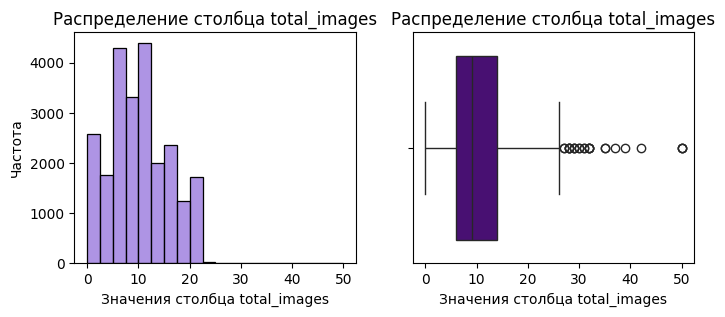

In [13]:
graph_hist(data, 'total_images')

Можно сказать, что аномальных значений нет.

#### last_price

In [14]:
data['last_price'].sort_values().unique() #поиск и сортировка уникальных значений столбца last_price

array([1.219e+04, 4.300e+05, 4.400e+05, ..., 4.013e+08, 4.200e+08,
       7.630e+08])

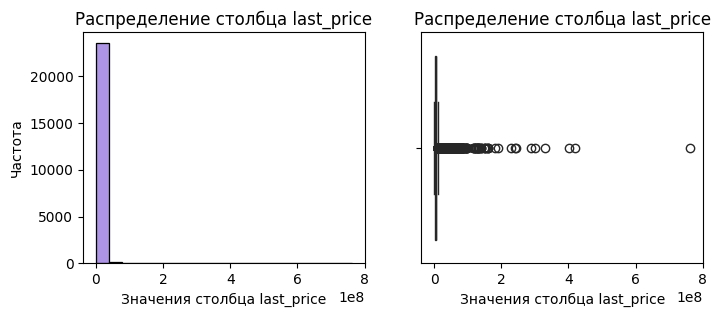

In [15]:
graph_hist(data, 'last_price') #построение гистограммы для столбца last_price

В целом цена квартиры может быть любой и слишком малых значений нет. 

В основной части объявлений стоимость квартиры не превосходит 50 млн рублей.
Однако стоит обратить внимание на слишком дорогие квартиры, возможно они будут выбиваться из общих зависимостей основной массы квартир и поэтому нужно будет рассматривать зависимости без них.

#### total_area

In [16]:
data['total_area'].sort_values().unique() #поиск и сортировка уникальных значений столбца total_area 

array([ 12. ,  13. ,  13.2, ..., 631. , 631.2, 900. ])

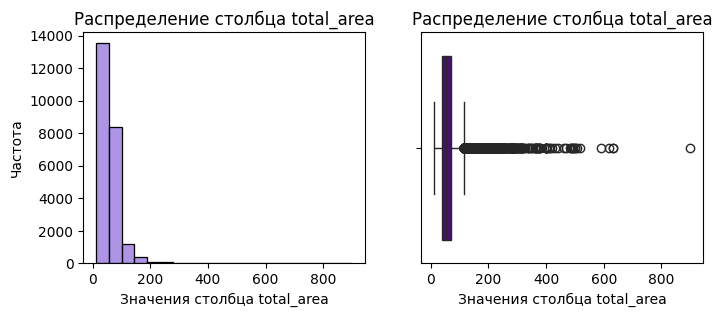

In [17]:
graph_hist(data, 'total_area') #построение гистограммы для столбца total_area

Нулевых и слишком малых значений нет - 12 м^2 может быть комната на продажу, а 900 м^2 вполне может быть площадь большого дома. 

Основная часть объявлений приходится на квартиры до 200 м^2.
Возможно, для определения зависимости цены квартиры от её площади нужно будет отбросить квартиры со слишком большими площадями (более 200 м^2).

#### first_day_exposition

In [18]:
data['first_day_exposition'].sort_values().unique() #поиск и сортировка уникальных значений столбца first_day_exposition

<DatetimeArray>
['2014-11-27 00:00:00', '2014-11-29 00:00:00', '2014-12-04 00:00:00',
 '2014-12-05 00:00:00', '2014-12-08 00:00:00', '2014-12-09 00:00:00',
 '2014-12-10 00:00:00', '2014-12-11 00:00:00', '2014-12-12 00:00:00',
 '2014-12-13 00:00:00',
 ...
 '2019-04-24 00:00:00', '2019-04-25 00:00:00', '2019-04-26 00:00:00',
 '2019-04-27 00:00:00', '2019-04-28 00:00:00', '2019-04-29 00:00:00',
 '2019-04-30 00:00:00', '2019-05-01 00:00:00', '2019-05-02 00:00:00',
 '2019-05-03 00:00:00']
Length: 1491, dtype: datetime64[ns]

Аномальных значений нет.

#### rooms

In [19]:
data['rooms'].sort_values().unique() #поиск и сортировка уникальных значений столбца rooms

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 19])

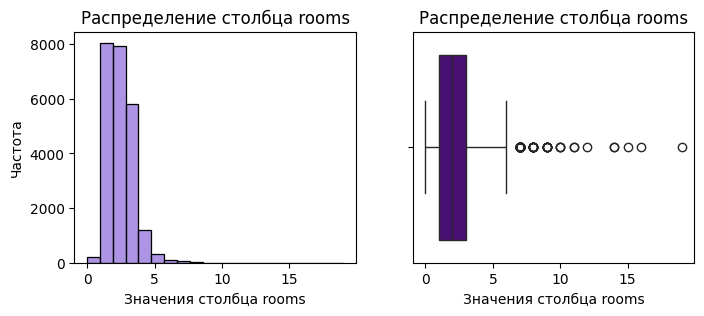

In [20]:
graph_hist(data, 'rooms') #построение гистограммы для столбца rooms

Большое количество комнат вполне может быть в больших домах. Количество комнат равное 0 может быть связано с тем, что их количество не указали при заполнении объявления. Для определения зависимости цены от количества комнат можно будет не использовать данные строчки. 

Основная часть объявлений приходится на квартиры с 1-3 комнатами. При определении зависимости цены квартиры от количества комнат будем использовать объявления, в которых указано до 8 комнат.

#### ceiling_height

In [21]:
data['ceiling_height'].sort_values().unique() #поиск и сортировка уникальных значений столбца ceiling_height

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

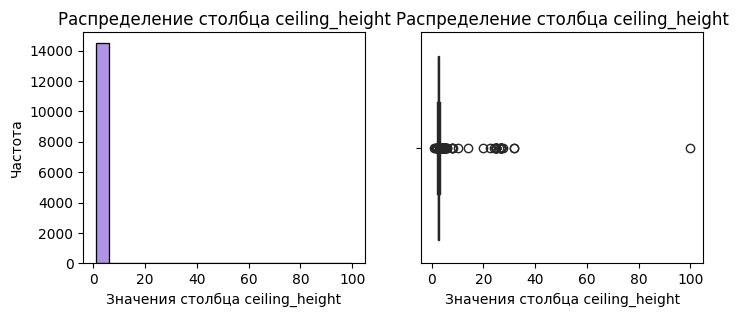

In [22]:
graph_hist(data, 'ceiling_height') #построение гистограммы для столбца ceiling_height

In [23]:
data['ceiling_height'] = data['ceiling_height'].replace(20.0, 2.0)
data['ceiling_height'] = data['ceiling_height'].replace(22.6, 2.3)
data['ceiling_height'] = data['ceiling_height'].replace(24.0, 2.4)
data['ceiling_height'] = data['ceiling_height'].replace(25.0, 2.5)
data['ceiling_height'] = data['ceiling_height'].replace(26.0, 2.6)
data['ceiling_height'] = data['ceiling_height'].replace(27.0, 2.7)
data['ceiling_height'] = data['ceiling_height'].replace(27.5, 2.8)
data['ceiling_height'] = data['ceiling_height'].replace(32.0, 3.2)
data['ceiling_height'] = data['ceiling_height'].replace(100.0, 10.0)

In [24]:
data['ceiling_height'].sort_values().unique()

array([ 1.  ,  1.2 ,  1.75,  2.  ,  2.2 ,  2.25,  2.3 ,  2.34,  2.4 ,
        2.45,  2.46,  2.47,  2.48,  2.49,  2.5 ,  2.51,  2.52,  2.53,
        2.54,  2.55,  2.56,  2.57,  2.58,  2.59,  2.6 ,  2.61,  2.62,
        2.63,  2.64,  2.65,  2.66,  2.67,  2.68,  2.69,  2.7 ,  2.71,
        2.72,  2.73,  2.74,  2.75,  2.76,  2.77,  2.78,  2.79,  2.8 ,
        2.81,  2.82,  2.83,  2.84,  2.85,  2.86,  2.87,  2.88,  2.89,
        2.9 ,  2.91,  2.92,  2.93,  2.94,  2.95,  2.96,  2.97,  2.98,
        2.99,  3.  ,  3.01,  3.02,  3.03,  3.04,  3.05,  3.06,  3.07,
        3.08,  3.09,  3.1 ,  3.11,  3.12,  3.13,  3.14,  3.15,  3.16,
        3.17,  3.18,  3.2 ,  3.21,  3.22,  3.23,  3.24,  3.25,  3.26,
        3.27,  3.28,  3.29,  3.3 ,  3.31,  3.32,  3.33,  3.34,  3.35,
        3.36,  3.37,  3.38,  3.39,  3.4 ,  3.42,  3.43,  3.44,  3.45,
        3.46,  3.47,  3.48,  3.49,  3.5 ,  3.51,  3.52,  3.53,  3.54,
        3.55,  3.56,  3.57,  3.58,  3.59,  3.6 ,  3.62,  3.63,  3.65,
        3.66,  3.67,

Есть аномальные значения высоты потолков - ниже 2,5 м и выше 3,6 м (поискала в интернете нормы высоты потолков). Слишком высокие значения (>20 м) скорее всего записаны в других единицах измерения. Для определения зависимости цены квартиры от высоты потолка надо будет использовать объявления с высотами потолков от 2,5 до 3,6 м.

#### floors_total

In [25]:
data['floors_total'].sort_values().unique() #поиск и сортировка уникальных значений столбца floors_total

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 33., 34., 35., 36., 37., 52., 60., nan])

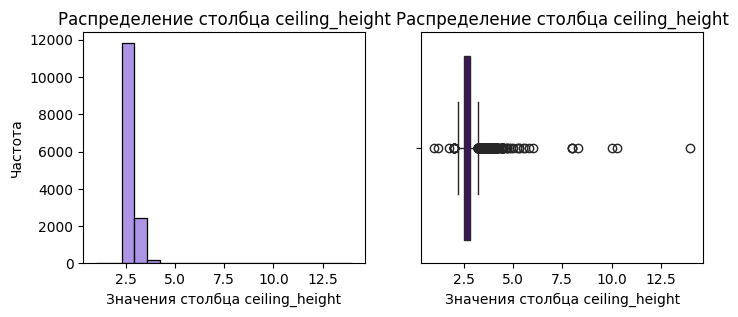

In [26]:
graph_hist(data, 'ceiling_height') #вывод общей гистограммы

В Санкт-Петербурге есть жилое здание с 37 этажами и вроде как оно самое высокое жилое в этом районе. Можно принять, что объявления с 52 и 60 этажами выбросы, но возможно такие здания действительно есть. Однако таких объявлений всего по 1 штуке, так что просто не будем их учитывать при определении зависимости.

#### living_area

In [27]:
data['living_area'].sort_values().unique() #поиск и сортировка уникальных значений столбца living_area

array([  2. ,   3. ,   5. , ..., 409. , 409.7,   nan])

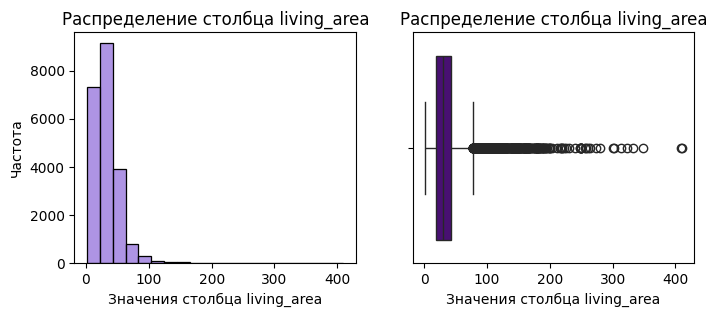

In [28]:
graph_hist(data, 'living_area') #вывод общей диаграммы 

Значения площадей меньше 8 м^2 (согласно нормам минимальный размер жилой комнаты) выглядят аномальными, но их не так уж и много. Однако при определении зависимости стоимости недвижимости от жилой площади эти объявления учитывать не будем (менее 8 и более 200 м^2).

#### floor

In [29]:
data['floor'].sort_values().unique() #поиск и сортировка уникальных значений столбца floor

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

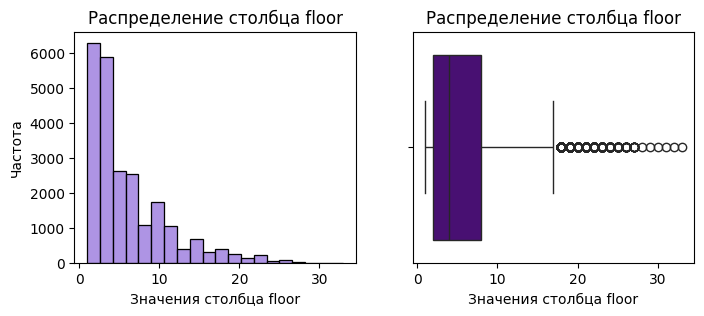

In [30]:
graph_hist(data, 'floor') #построение гистограммы для столбца floor

Нет аномальных значений.

#### is_apartment

In [31]:
data['is_apartment'].sort_values().unique() #поиск и сортировка уникальных значений столбца is_apartment

array([False,  True])

Нет аномальных значений.

#### studio

In [32]:
data['studio'].sort_values().unique() #поиск и сортировка уникальных значений столбца studio

array([False,  True])

Нет аномальных значений.

#### open_plan

In [33]:
data['open_plan'].sort_values().unique() #поиск и сортировка уникальных значений столбца open_plan

array([False,  True])

Нет аномальных значений.

#### kitchen_area

In [34]:
data['kitchen_area'].sort_values().unique() #поиск и сортировка уникальных значений столбца kitchen_area

array([  1.3 ,   2.  ,   2.3 ,   2.4 ,   2.89,   3.  ,   3.2 ,   3.3 ,
         3.4 ,   3.5 ,   3.7 ,   3.8 ,   4.  ,   4.1 ,   4.2 ,   4.3 ,
         4.4 ,   4.5 ,   4.6 ,   4.7 ,   4.8 ,   4.9 ,   5.  ,   5.04,
         5.06,   5.1 ,   5.14,   5.2 ,   5.21,   5.23,   5.25,   5.28,
         5.29,   5.3 ,   5.31,   5.33,   5.35,   5.4 ,   5.42,   5.44,
         5.47,   5.49,   5.5 ,   5.53,   5.59,   5.6 ,   5.61,   5.62,
         5.64,   5.65,   5.68,   5.7 ,   5.74,   5.75,   5.78,   5.8 ,
         5.82,   5.85,   5.86,   5.9 ,   5.91,   6.  ,   6.02,   6.03,
         6.1 ,   6.16,   6.19,   6.2 ,   6.22,   6.23,   6.24,   6.25,
         6.26,   6.27,   6.28,   6.3 ,   6.31,   6.33,   6.35,   6.36,
         6.37,   6.4 ,   6.47,   6.5 ,   6.55,   6.58,   6.6 ,   6.61,
         6.62,   6.65,   6.7 ,   6.72,   6.73,   6.76,   6.77,   6.8 ,
         6.82,   6.83,   6.84,   6.86,   6.9 ,   6.91,   6.93,   6.95,
         7.  ,   7.02,   7.03,   7.06,   7.09,   7.1 ,   7.12,   7.15,
      

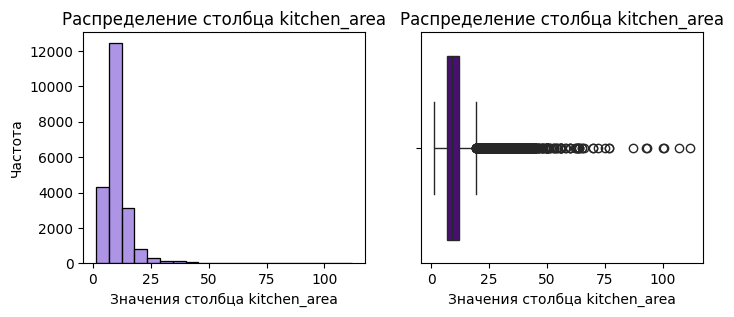

In [35]:
graph_hist(data, 'kitchen_area') #вывод общей диаграммы 

Возможно действительно есть кухни с площадью 112 квадратных метров, но кухонь с площадью более 40 м^2 не так уж и много, так что скорее всего такие объявления не повлияют результат. Их можно будет не учитывать при определении зависимости цены квартиры.

#### balcony

In [36]:
data['balcony'].sort_values().unique() #поиск и сортировка уникальных значений столбца balcony

array([0, 1, 2, 3, 4, 5])

Нет аномальных значений.

#### airports_nearest

In [37]:
data['airports_nearest'].sort_values().unique() #поиск и сортировка уникальных значений столбца airports_nearest

array([    0.,  6450.,  6914., ..., 84853., 84869.,    nan])

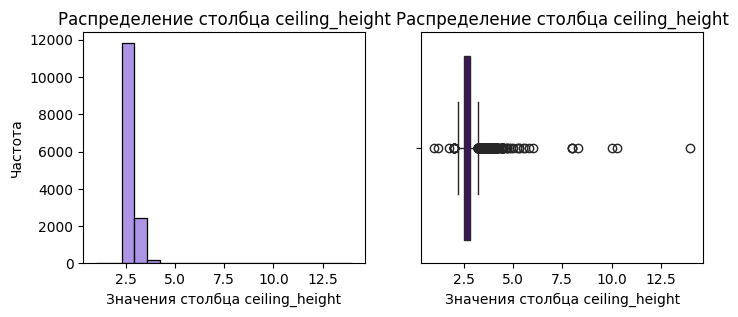

In [38]:
graph_hist(data, 'ceiling_height') #вывод общей диаграммы 

Есть одно объявление с аномальным расстоянием до аэропорта - 0 м. Не будем его учитывать при определении зависимости.

#### cityCenters_nearest

In [39]:
data['cityCenters_nearest'].sort_values().unique() #поиск и сортировка уникальных значений столбца cityCenters_nearest

array([  181.,   208.,   215., ..., 65952., 65968.,    nan])

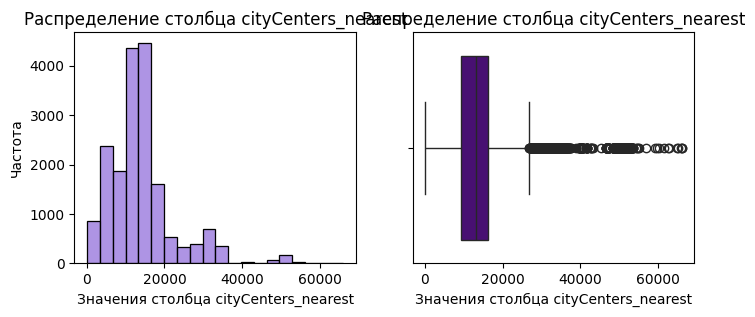

In [40]:
graph_hist(data, 'cityCenters_nearest')  #построение гистограммы для столбца cityCenters_nearest

В целом все значения имеют место быть.

#### parks_around3000

In [41]:
data['parks_around3000'].sort_values().unique() #поиск и сортировка уникальных значений столбца parks_around3000

array([ 0.,  1.,  2.,  3., nan])

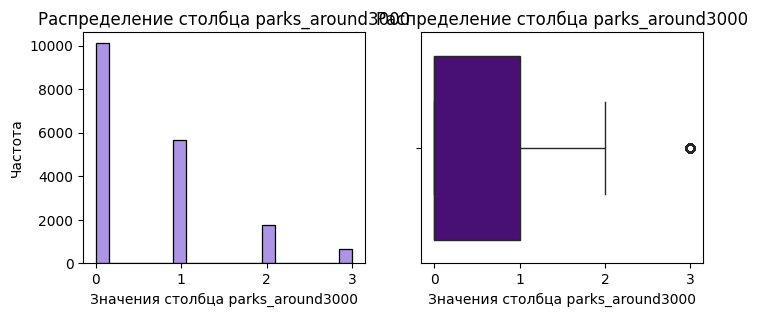

In [42]:
graph_hist(data, 'parks_around3000')

Нет аномальных значений.

#### parks_nearest

In [43]:
data['parks_nearest'].sort_values().unique() #поиск и сортировка уникальных значений столбца parks_nearest

array([1.000e+00, 3.000e+00, 4.000e+00, 7.000e+00, 9.000e+00, 1.000e+01,
       1.100e+01, 1.200e+01, 1.300e+01, 1.400e+01, 1.500e+01, 1.600e+01,
       1.700e+01, 1.800e+01, 1.900e+01, 2.000e+01, 2.100e+01, 2.200e+01,
       2.300e+01, 2.400e+01, 2.700e+01, 2.800e+01, 3.000e+01, 3.200e+01,
       3.300e+01, 3.400e+01, 3.500e+01, 3.600e+01, 3.700e+01, 3.800e+01,
       3.900e+01, 4.000e+01, 4.100e+01, 4.200e+01, 4.300e+01, 4.400e+01,
       4.500e+01, 4.600e+01, 4.700e+01, 4.800e+01, 4.900e+01, 5.000e+01,
       5.100e+01, 5.200e+01, 5.300e+01, 5.400e+01, 5.500e+01, 5.600e+01,
       5.700e+01, 5.800e+01, 5.900e+01, 6.000e+01, 6.100e+01, 6.200e+01,
       6.300e+01, 6.400e+01, 6.500e+01, 6.600e+01, 6.700e+01, 6.800e+01,
       6.900e+01, 7.100e+01, 7.200e+01, 7.300e+01, 7.400e+01, 7.500e+01,
       7.600e+01, 7.700e+01, 7.800e+01, 8.000e+01, 8.100e+01, 8.200e+01,
       8.300e+01, 8.400e+01, 8.500e+01, 8.600e+01, 8.700e+01, 8.800e+01,
       9.000e+01, 9.100e+01, 9.200e+01, 9.300e+01, 

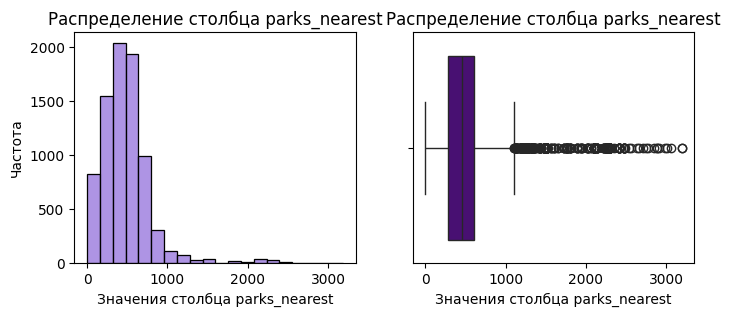

In [44]:
graph_hist(data, 'parks_nearest') #построение гистограммы для столбца parks_nearest

Все значения имеют место быть.

#### ponds_around3000

In [45]:
data['ponds_around3000'].sort_values().unique() #поиск и сортировка уникальных значений столбца ponds_around3000

array([ 0.,  1.,  2.,  3., nan])

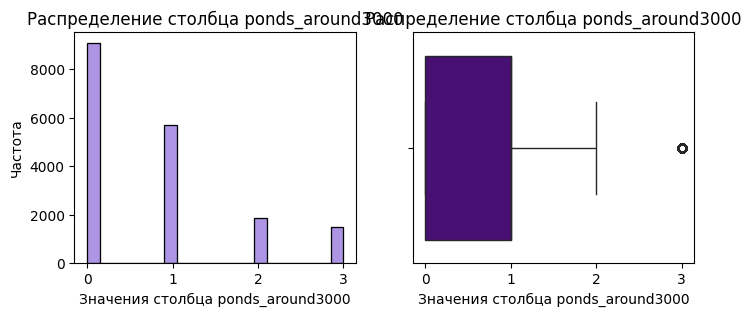

In [46]:
graph_hist(data, 'ponds_around3000')

Нет аномальных значений.

#### ponds_nearest

In [47]:
data['ponds_nearest'].sort_values().unique() #поиск и сортировка уникальных значений столбца ponds_nearest

array([  13.,   16.,   19., ..., 1341., 1344.,   nan])

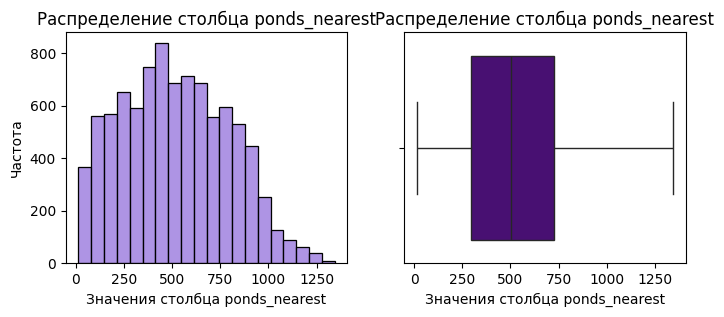

In [48]:
graph_hist(data, 'ponds_nearest')

Нет аномальных значений.

#### days_exposition

In [49]:
data['days_exposition'].sort_values().unique() #поиск и сортировка уникальных значений столбца days_exposition 

array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.572e+03, 1.580e+03,
             nan])

Объявления о продаже могут висеть как и несколько лет, так и продажа может произойти в тот же день.

Все столбцы были просмотрены предмет аномальных значений. Объявления с аномальными значениями в каком-то из столбцов не были удалены, поскольку могут содержать важную для исследования информацию в других столбцах. Для некоторых столбцов написаны рекомендации по использованию тех или иных значений, что будет учтено далее.

## Посчитайте и добавьте в таблицу новые столбцы

In [50]:
#расчет цены за квадратный метр
data['metr_price'] = np.round(data['last_price'] / data['total_area'], 2) 

#определение дня недели размещения объявления
data['weekday'] = data['first_day_exposition'].dt.dayofweek 

#определение месяца размещения объявления
data['month'] = data['first_day_exposition'].dt.month 

#определение года размещения объявления
data['year'] = data['first_day_exposition'].dt.year 

In [51]:
data['type_floor'] = 0 #создание нового столбца с типом этажа
def type_floor(row): #функция для определения типа этажа
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['type_floor'] = data.apply(type_floor, axis=1) #заполнение столбца с типами этажа

In [52]:
#определение расстояния до центра города в км с округлением до километра

data['center_distance'] = np.round(data['cityCenters_nearest'] / 1000, 0) 

## Исследовательский анализ данных

### Изучение параметров объявления о продаже

In [53]:
#функция для построения ограниченных распределений
def hist_lim(data, column, xlim):
    plt.figure(figsize=(5, 5))
    plt.xlabel(f'Значения столбца {column}')
    plt.ylabel('Частота')
    plt.title(f'Распределение столбца {column}')
    plt.xlim(0, xlim)
    sns.histplot(data[column], color='MediumPurple')

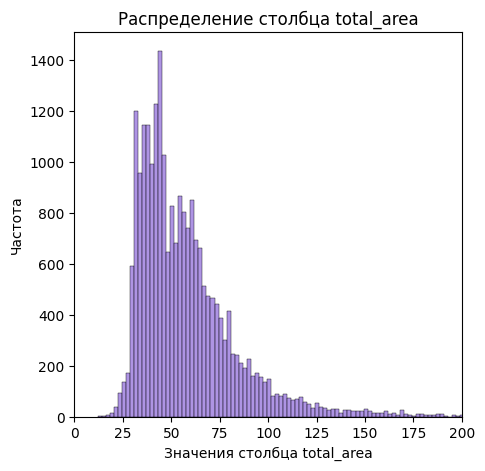

In [54]:
 #построение гистограммы для столбца total_area
hist_lim(data, 'total_area', 200)

Можно предположить, что средняя площадь квартир около 50 м^2.

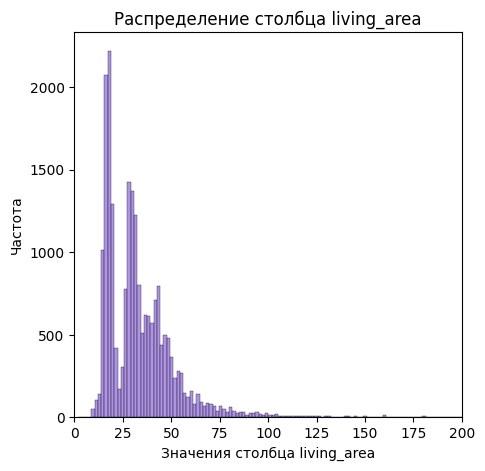

In [55]:
#построение гистограммы для столбца living_area
hist_lim(data, 'living_area', 200)

Средняя жилая площадь составляет около 30 м^2.

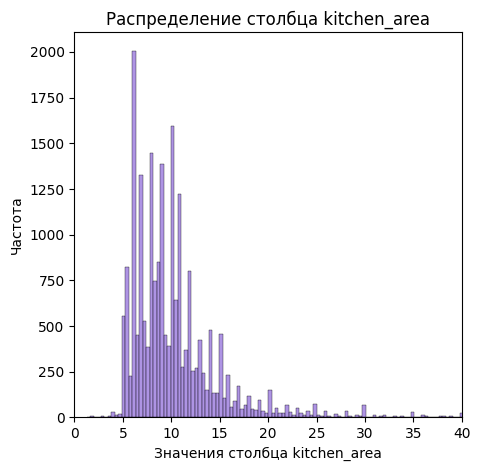

In [56]:
#построение гистограммы для столбца kitchen_area
hist_lim(data, 'kitchen_area', 40)

Средняя площадь кухни около 10 м^2.

Распределения общей и жилой площади и площади кухни выглядят примерно одинаково - это не нормальное распределение, а оно смещено и имеет длинный хвост в сторону больших значений. Это может натолкнуть на мысль о том, что распределение цены квартир будет выглядет примерно также (если между этими данными есть зависимость).

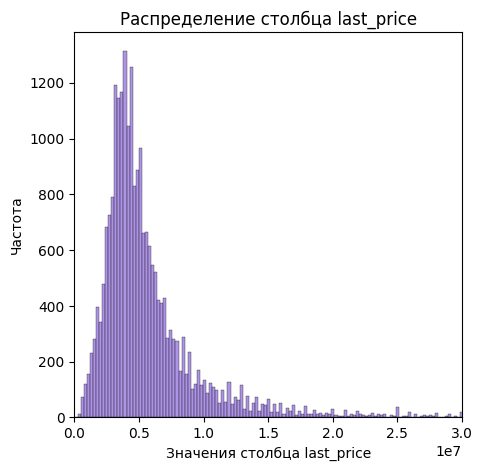

In [57]:
#построение гистограммы для столбца last_price
hist_lim(data, 'last_price', 30000000)

Средняя цена квартиры составляет около 5 млн рублей.
Распределение цены также имеет смещенный вид и длинный хвост в области больших значений. Данное распределение очень похоже на распределение площадей (общей, жилой и кухни).

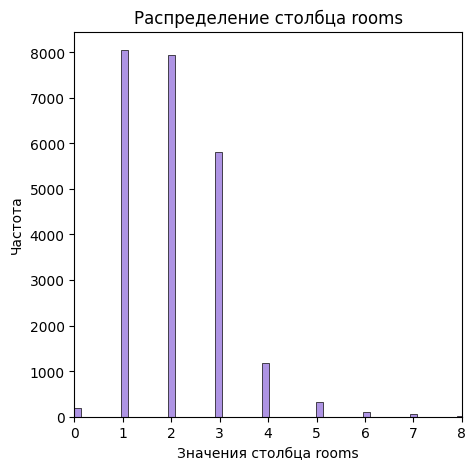

In [58]:
#построение гистограммы для столбца rooms
hist_lim(data, 'rooms', 8)

В среднем квартира состоит из 1-3 комнат.

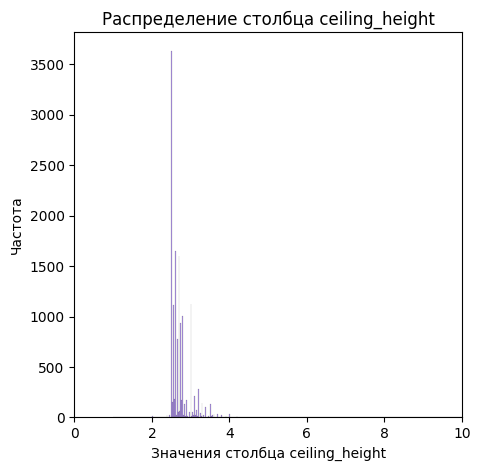

In [59]:
#построение гистограммы для столбца ceiling_height
hist_lim(data, 'ceiling_height', 10)

Высота потолков представляет собой довольно узкое распределение. В основном высота потолков составляет около 3 м.

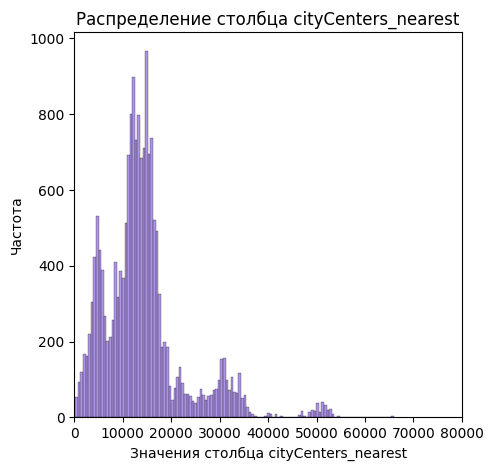

In [60]:
#построение гистограммы для столбца cityCenters_nearest
hist_lim(data, 'cityCenters_nearest', 80000)

Похоже на нормальное распределение с длинным хвостом в больших значениях.

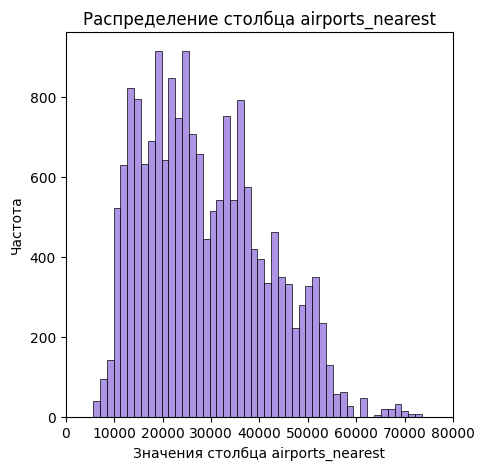

In [61]:
#построение гистограммы для столбца airports_nearest
hist_lim(data, 'airports_nearest', 80000)

Похоже на смещенное распределение с хвостом в больших значениях.

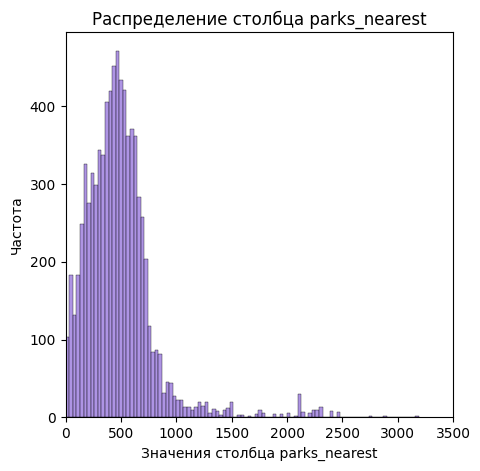

In [62]:
#построение гистограммы для столбца parks_nearest
hist_lim(data, 'parks_nearest', 3500)

Похоже на предыдущие распределения по расстоянию от центра и от аэропорта.

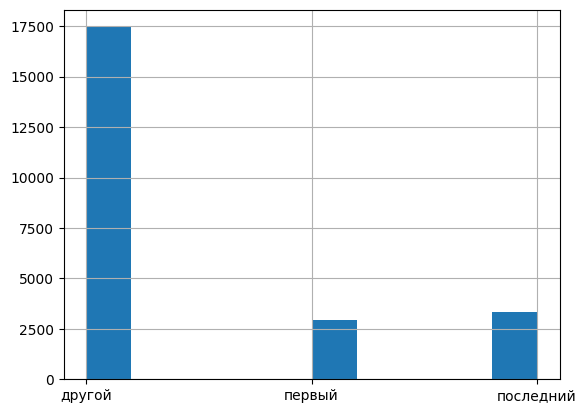

In [63]:
#построение гистограммы для столбца type_floor
data['type_floor'].hist(); 

Аномальных значений в данном столбце нет. Распределение выглядит вполне логичным, так как количество первых и последних этажей примерно одинаковое, а самой многочисленной является группа 'другие'.


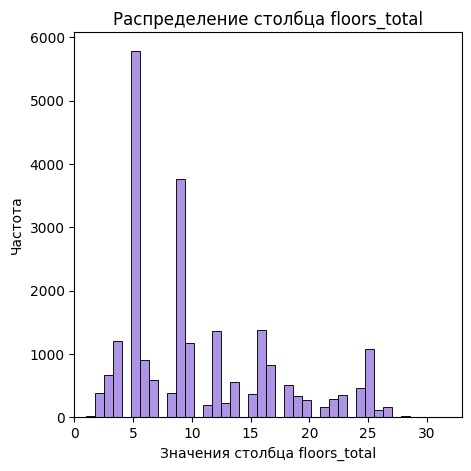

In [64]:
#построение гистограммы для столбца floors_total
hist_lim(data, 'floors_total', 33)

В основном квартиры продаются в пяти и десятиэтажных домах.

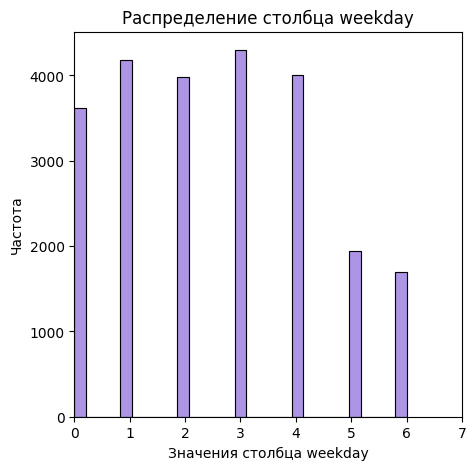

In [65]:
#построение гистограммы для столбца weekday
hist_lim(data, 'weekday', 7) 

Из гистограммы видно, что в выходные объявления выкладываются реже, а чаще всего во вторник и в четверг.

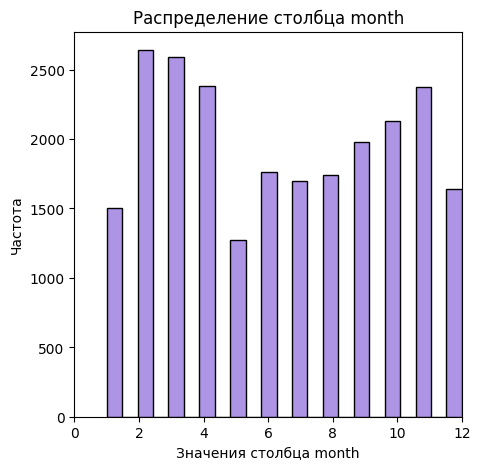

In [66]:
#построение гистограммы для столбца weekday
hist_lim(data, 'month', 12) 

Реже всего объявления выкладывали в декабре, январе и мае. Возможно это связано с большим количеством праздничных дней в этих месяцах. 

Чаще всего выкладывали в феврале, марте и апреле. (Продажи после "зимней спячки"? :))

### Время продажи квартиры

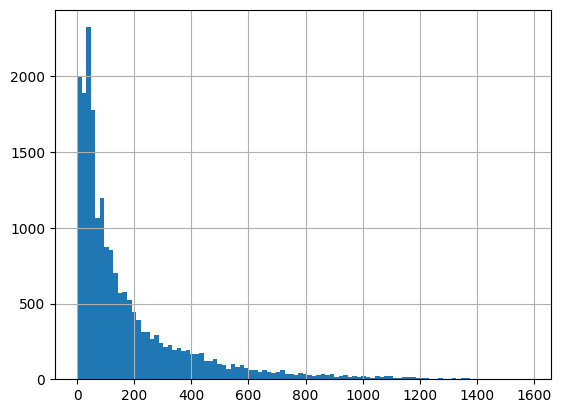

In [67]:
data['days_exposition'].hist(bins=100); #построение гистограммы для столбца days_exposition

In [68]:
data['days_exposition'].mean() # расчет среднего значения дней продажи квартиры

180.88863436982163

In [69]:
data['days_exposition'].median() #расчет медианного значения дней продажи квартиры

95.0

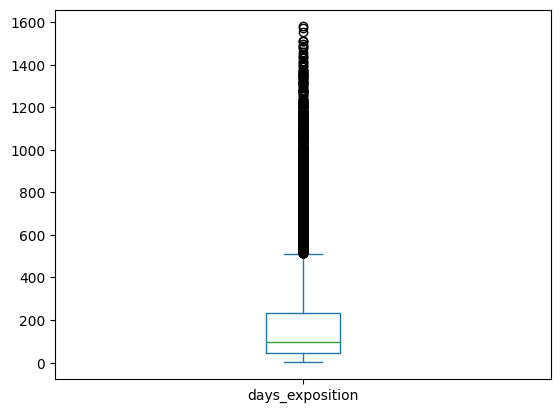

In [70]:
data['days_exposition'].plot(kind='box');

In [71]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Среднее значение дней продажи равняется примерно 180 дней, что составляет 6 месяцев. Медианное значение дней продажи равняется 95 дням, что составляет около 3 месяцев.

По сравнению с медианным значением среднее значение сильно сдвинуто в сторону больших значений, поскольку встречаются объявления, которые висели в продаже несколько лет. 

Кажется очень быстрые объявления мы выделим не можем, поскольку внизу "усов" у нас нет значений, очень долгими можно считать от 500 дней (судя по тем значениям, которые находятся выше "усов").

### Факторы, влияющие на стоимость квартиры

#### Общая площадь


0.6536750579657244

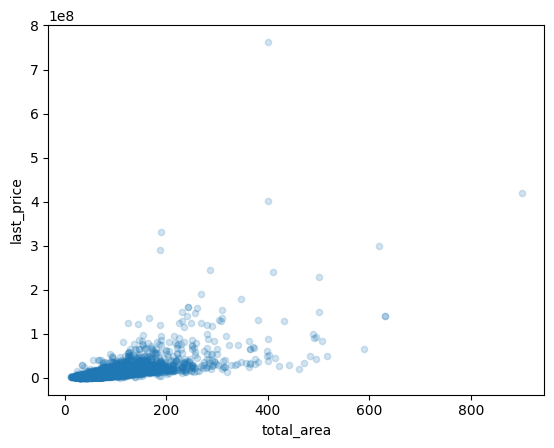

In [72]:
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.2) #построение диаграммы рассеивания
data['last_price'].corr(data['total_area']) #расчет коэффициента корреляции

0.7196361028560313

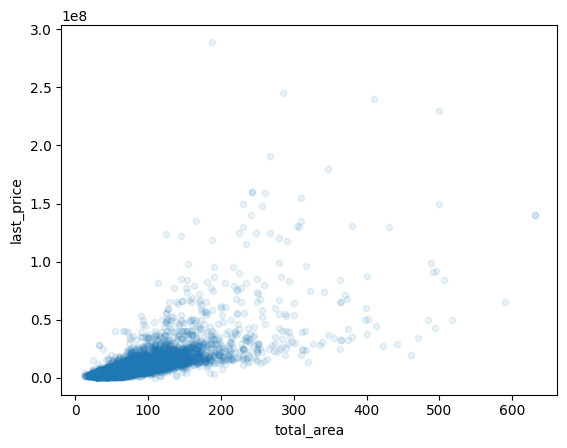

In [73]:
data_price = data.query('last_price < 300000000') #выбор объявлений, цена в которых не превышает 300 млн рублей.
data_price.plot(x='total_area', y='last_price', kind='scatter', alpha=0.1) #построение диаграммы рассеивания
data_price['last_price'].corr(data_price['total_area']) #расчет коэффициента корреляции

0.6588354501962441

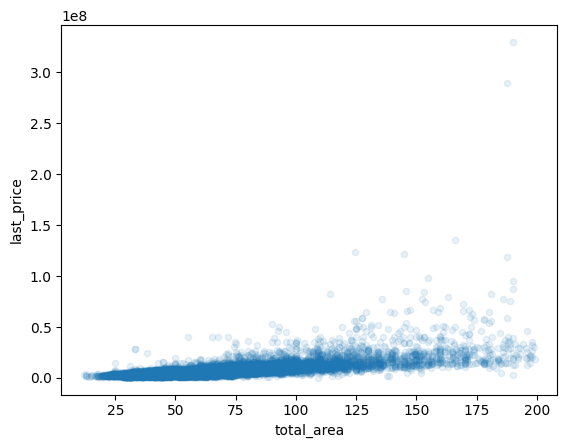

In [74]:
data_total_area = data.query('total_area < 200') #выбор объявлений, в которых общая площадь не превышает 200 м^2
data_total_area.plot(x='total_area', y='last_price', kind='scatter', alpha=0.1) #построение диаграммы рассеивания
data_total_area['last_price'].corr(data_total_area['total_area']) #расчет коэффициента корреляции

Попробовала определить 3 коэффциента корреляции - исходные данные, данные без объявлений с нетипично дорогими квартирами, данные без объявлений с нетипично большими площадями.
В целом, по значению коэффициента корреляции и виду диаграмм рассеивания можно говорить о сильной положительной взаимосвязи стоимости квартиры и общей площади квартиры.

#### Жилая площадь

0.5664915336952648

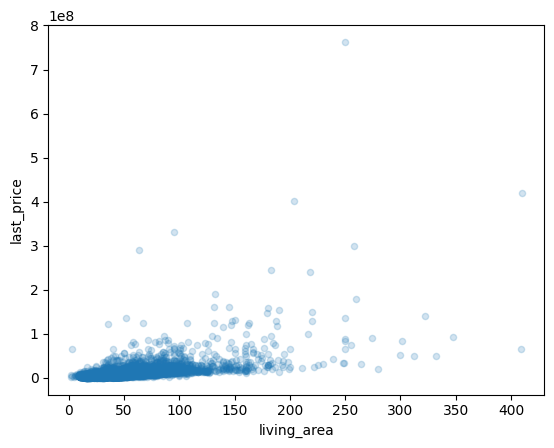

In [75]:
data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.2) #построение диаграммы рассеивания
data['last_price'].corr(data['living_area']) #расчет коэффициента корреляции

0.635536995263894

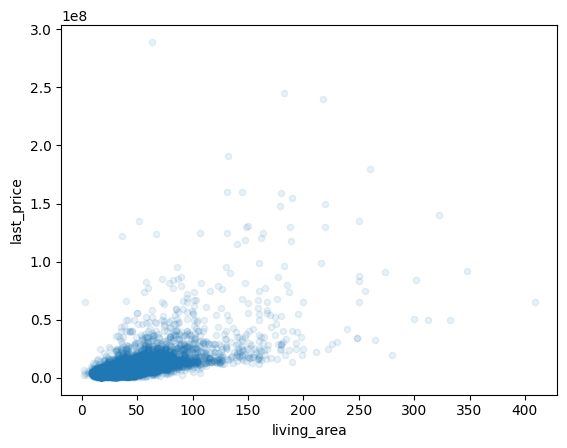

In [76]:
data_price.plot(x='living_area', y='last_price', kind='scatter', alpha=0.1) #построение диаграммы рассеивания
data_price['last_price'].corr(data_price['living_area']) #расчет коэффициента корреляции

0.5927791033265972

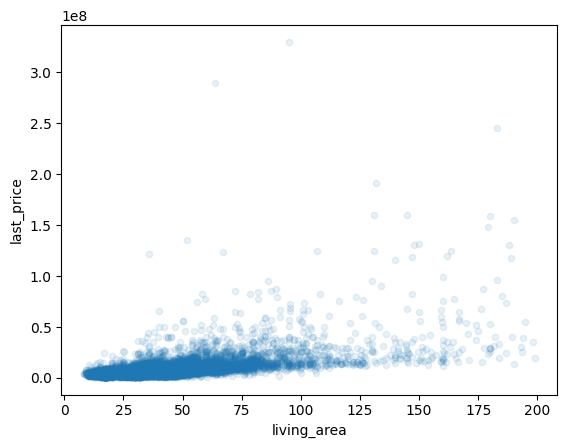

In [77]:
data_living_area = data.query('8 < living_area < 200') #выбор объявлений с жилой площадью от 8 до 200 м^2
data_living_area.plot(x='living_area', y='last_price', kind='scatter', alpha=0.1) #построение диаграммы рассеивания
data_living_area['last_price'].corr(data_living_area['living_area']) #расчет коэффициента корреляции

3 коэффциента корреляции - исходные данные, данные без объявлений с нетипично дорогими квартирами, данные без объявлений с нетипично малыми и большими жилыми площадями.
По значению коэффициента корреляции и виду диаграмм рассеивания можно говорить о положительной взаимосвязи стоимости квартиры и общей площади квартиры.

#### Площадь кухни

0.5198690130216387

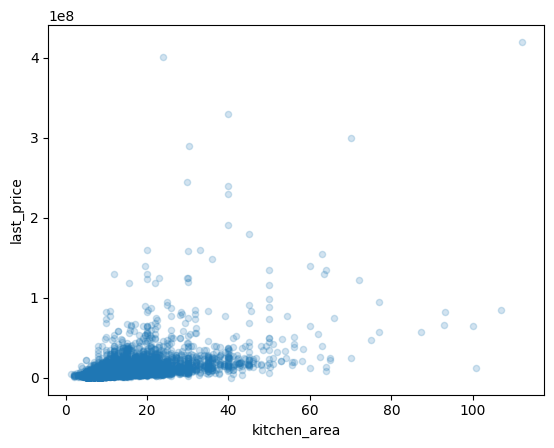

In [78]:
data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.2) #построение диаграммы рассеивания
data['last_price'].corr(data['kitchen_area']) #расчет коэффициента корреляции

0.5379553320460977

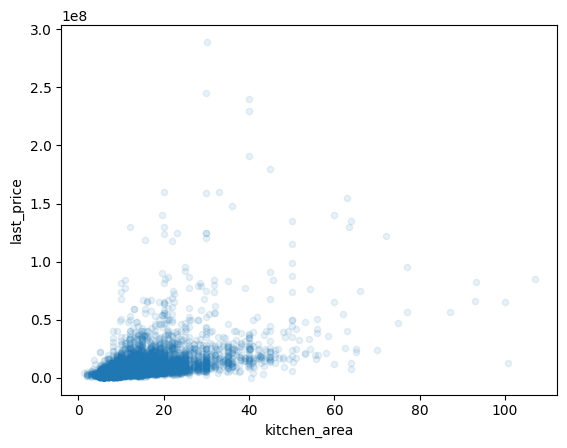

In [79]:
data_price.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.1) #построение диаграммы рассеивания
data_price['last_price'].corr(data_price['kitchen_area']) #расчет коэффициента корреляции

0.4636123992597341

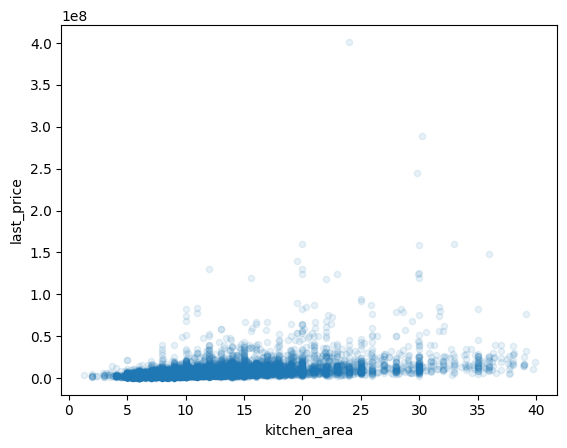

In [80]:
data_kitchen_area = data.query('kitchen_area < 40') #выбор объявлений, в которых площадь кухни не превышает 40 м^2
data_kitchen_area.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.1) #построение диаграммы рассеивания
data_kitchen_area['last_price'].corr(data_kitchen_area['kitchen_area']) #расчет коэффициента корреляции

3 коэффциента корреляции - исходные данные, данные без объявлений с нетипично дорогими квартирами, данные без объявлений с нетипично большими площадями кухни.
Присутствует положительная взаимосвязь между ценой квартиры и площадью кухни.

#### Количество комнат

0.351196683647629

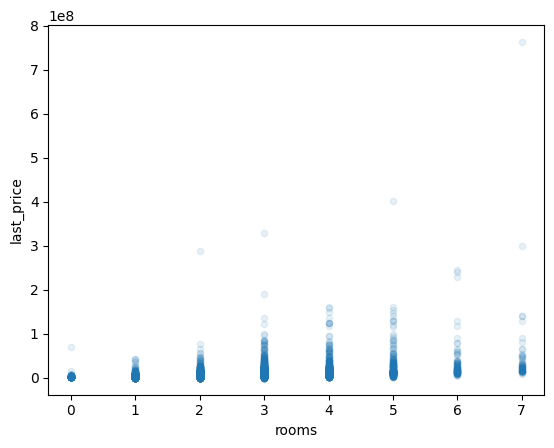

In [81]:
data_rooms = data.query('rooms < 8') #выбор объявлений, в которых количество комнат не превышает 7 
data_rooms.plot(x='rooms', y='last_price', kind='scatter', alpha=0.1) #построение диаграммы рассеивания
data_rooms['last_price'].corr(data_rooms['rooms']) #расчет коэффициента корреляции

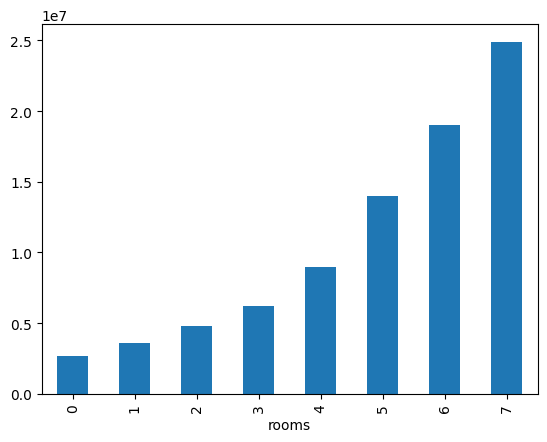

In [82]:
data_rooms.groupby('rooms')['last_price'].median().plot(kind='bar'); #расчет медианного значения цены квартиры в зависимости от количества комнат

Присутствует сильная положительная взаимосвязь между ценой квартиры и количеством комнат.

#### Тип этажа

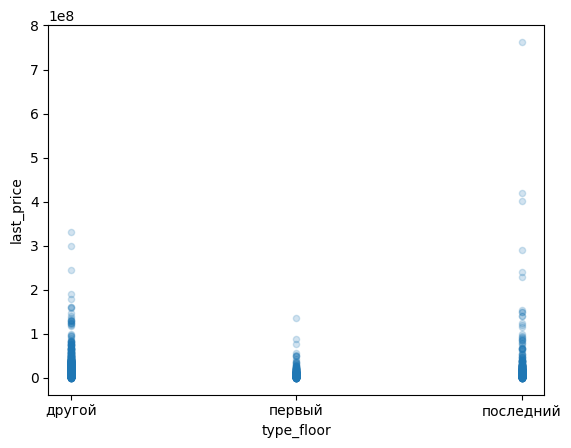

In [83]:
data.plot(x='type_floor', y='last_price', kind='scatter', alpha=0.2); #построение диаграммы рассеивания

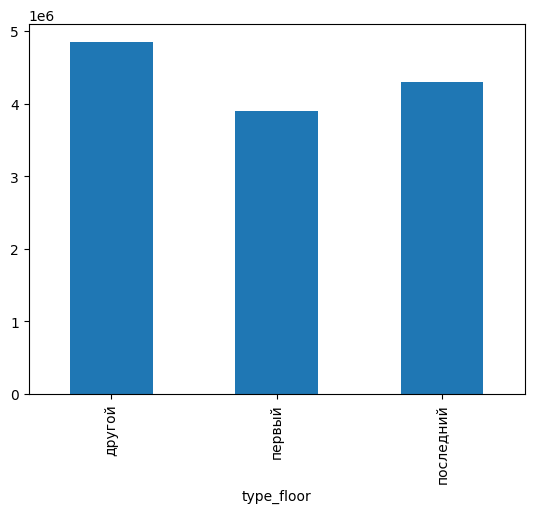

In [84]:
data.groupby('type_floor')['last_price'].median().plot(kind='bar'); #расчет медианного значения цены квартиры в зависимости от типа этажа

Цена квартиры на первом этаже в среднем (по медиане) меньше, чем на других этажах, также квартиры на последнем этаже дороже, чем на первом, но дешевле, чем на других этажах. 

#### День размещения объявления


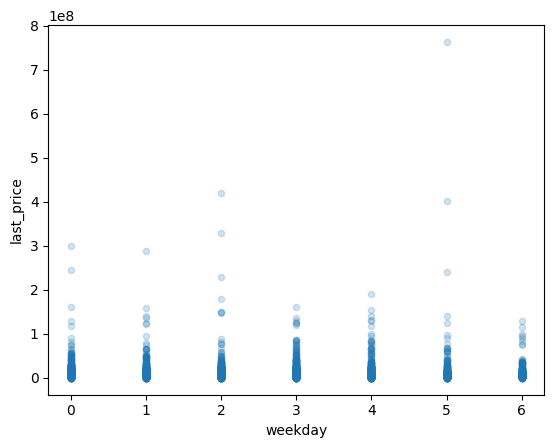

In [85]:
data.plot(x='weekday', y='last_price', kind='scatter', alpha=0.2); #построение диаграммы рассеивания

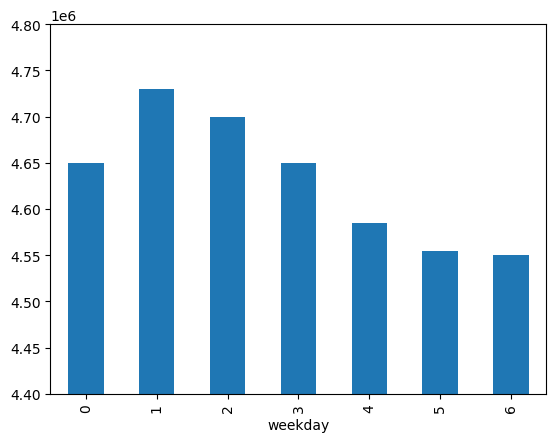

In [86]:
data.groupby('weekday')['last_price'].median().plot(kind='bar', ylim=(4400000, 4800000));

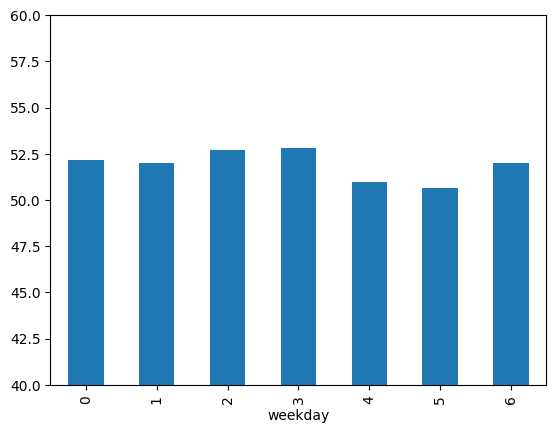

In [87]:
data.groupby('weekday')['total_area'].median().plot(kind='bar', ylim=(40, 60));

Наибольшая средняя (медианная) цена квартиры наблюдалась в объявлениях, опубликованных во вторник, наименьшая - в выходные. В целом это коррелирует с количеством объявлений, выложенных в эти дни - больше объявлений выложено в будние дни, меньше в выходные.

#### Месяц размещения объявления

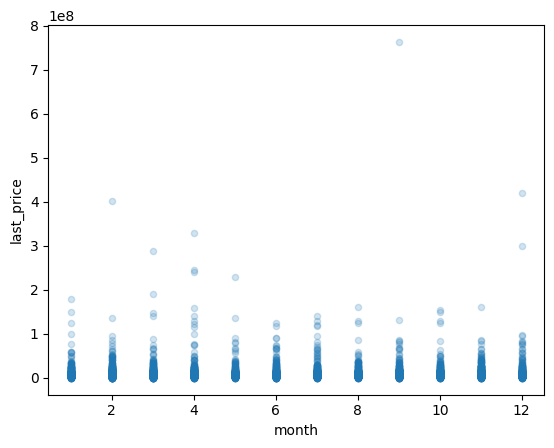

In [88]:
data.plot(x='month', y='last_price', kind='scatter', alpha=0.2); #построение диаграммы рассеивания

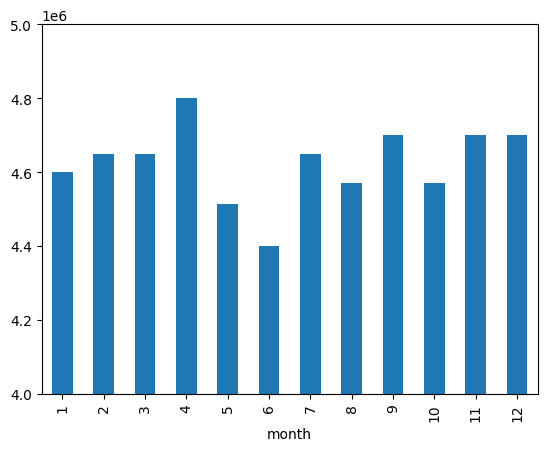

In [89]:
data.groupby('month')['last_price'].median().plot(kind='bar', ylim=(4000000, 5000000));

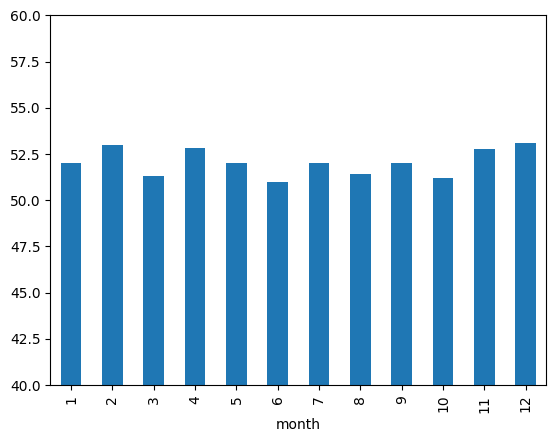

In [90]:
data.groupby('month')['total_area'].median().plot(kind='bar', ylim=(40, 60));

Наибольшая средняя (медианная) цена квартиры наблюдалась в объявлениях, опубликованных в апреле, наименьшая - в мае и июне. Это может быть связано с количеством выложенных объявлений в эти месяцы.

#### Год размещения объявления

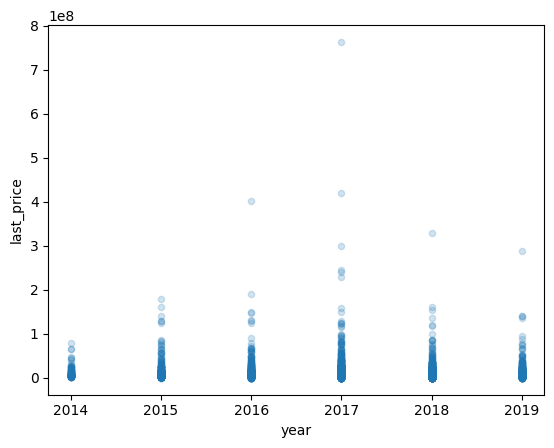

In [91]:
data.plot(x='year', y='last_price', kind='scatter', alpha=0.2); #построение диаграммы рассеивания

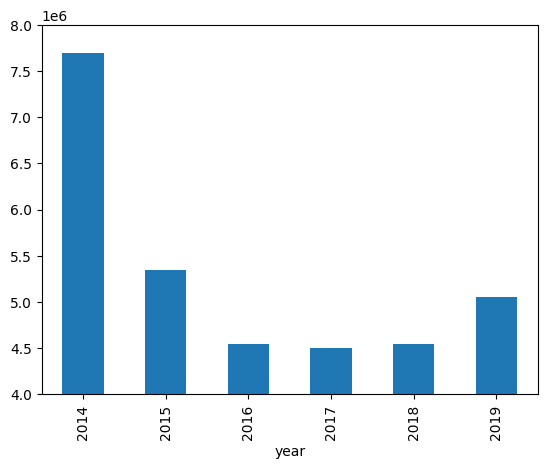

In [92]:
data.groupby('year')['last_price'].median().plot(kind='bar', ylim=(4000000, 8000000));

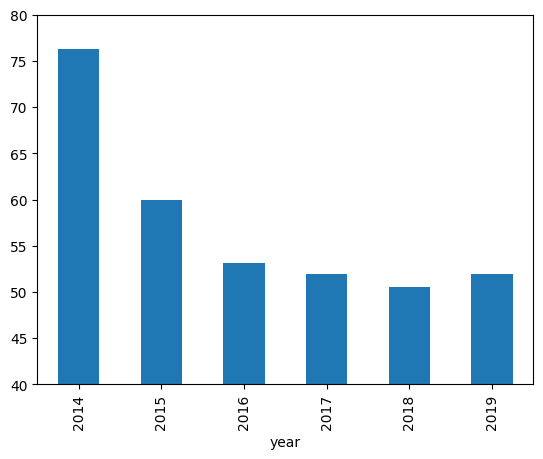

In [93]:
data.groupby('year')['total_area'].median().plot(kind='bar', ylim=(40, 80));

Можно отметить снижение средней стоимости квартиры с 2014 по 2017 год, а к 2019 снова виднеется рост. Возможно это связано с тем, что с 2014 года падает средняя площадь продаваемых квартир, поэтому и снижается цена.

Больше всего на стоимость квартиры влияет ее общая площадь. Остальные параметры (жилая площадь, площадь кухни, количество комнат) косвенно связаны с общей площадью, точнее определяют итоговую общую площадь. 

Тип этажа также имеет значение - квартиры на первом этаже имеют наименьшую стоимость, затем идут квартиры на последнем этаже, а потом уже все остальные. 

День и месяц размещения особо не влияет на конечную стоимость квартиры. Возможно год размещения влияет на стоимость квартиры, поскольку изменялась средняя площадь продаваемых квартир в течение этих лет, что может быть связано с доступными предложениями рынка.

### Цена квадратного метра в зависимости от населенного пункта

locality_name
Санкт-Петербург      15721
поселок Мурино         556
поселок Шушары         440
Всеволожск             398
Пушкин                 369
Колпино                338
поселок Парголово      327
Гатчина                307
деревня Кудрово        299
Выборг                 237
Name: count, dtype: int64


,metr_price
locality_name,
Всеволожск,65789.470
Выборг,58158.320
Гатчина,67796.610
Колпино,74723.745
Пушкин,100000.000
Санкт-Петербург,104761.900
деревня Кудрово,91860.470
поселок Мурино,85878.465
поселок Парголово,91642.860


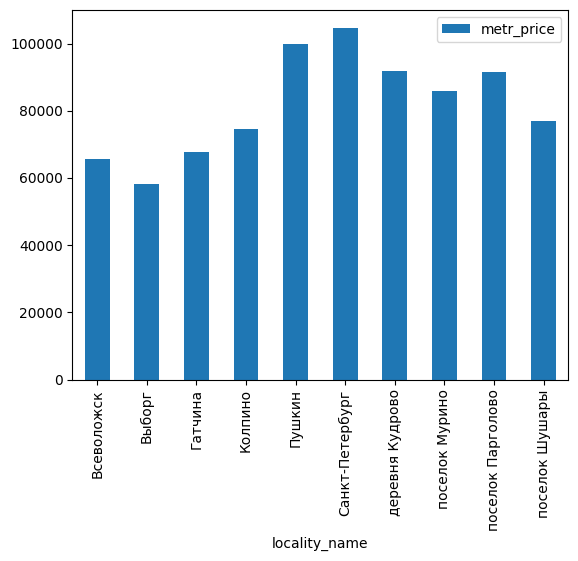

In [94]:
data_location = data['locality_name'].value_counts().head(10)
print(data_location)
median_metr_price = data.query('locality_name.isin(@data_location.index)').pivot_table(index='locality_name', values='metr_price', aggfunc='median')
median_metr_price.plot(kind='bar')
median_metr_price

Наибольшая средняя цена за квадратный метр в Санкт-Петербурге - 104761 рублей, наименьшая - в Выборге - 58158 рублей.

### Зависимость цены от расстояния до центра в Санкт-Петербурге

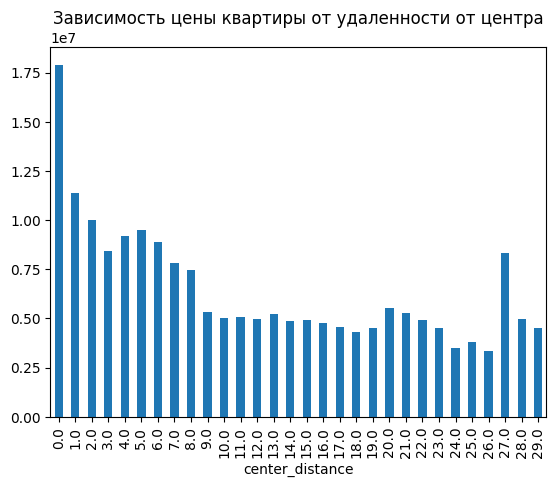

In [95]:
data_SPb = data.query('locality_name == "Санкт-Петербург"')
data_SPb.groupby('center_distance')['last_price'].median().plot(kind='bar', title = 'Зависимость цены квартиры от удаленности от центра');


Наблюдается обратная зависимость цены квартиры от расстояния от центра города - при удалении от центра города цена квартиры уменьшается.

## Общий вывод

В данном проекте были проанализированны данные объявлений о продаже квартир в Санкт-Петербурге и близлежащих населенных пунктах. Целью проекта было определение влияние таких параметров объявления, как общая площадь, жилая площадь, площадь кухни, количество комнат, тип этажа и дата размещения объявления, влияют на итоговую цену квартиры.

Предварительно данные были подготовлены, а затем проанализированы:
1. Обнаружены пропуски в столбцах ceiling_height, floors_total, living_area, kitchen_area, is_apartment, locality_name, которые связаны с тем, что эти параметры не указаны в объявлении. Пропуски в столбцах airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest вызваны отсутствием данных в геосервисах.
2. Пропуски были заполнены только в столбцах is_apartment (значениями False) и balcony (значениями 0).
3. В столбце first_day_exposition тип данных был изменен для дальнейшей работы с датой (определение дня недели, месяца, года размещения объявления). Также тип данных был заменен в столбце balcony на целочисленный.
4. В столбце locality_name были заменены неявные дубликаты, возникшие из-за вариации написания слова "поселок" - буква ё была заменена на е.
5. Все столбцы были проанализированы на наличие аномальных значений. Однако данные значения не удалялись, поскольку в других столбцах такого объявления могли содержатся важные данные. Поэтому были написаны рекомендации для каждого столбца диапазон какиех значений стоит использовать для анализа.
6. Были добавлены новые столбцы - цена квадратного метра, день недели, месяц и год размещения объявления, тип этажа, расстояние от центра города в километрах.
7. Были проанализированы гистограммы распределения для типа этажа, дня недели и месяца размещения объявления. Установлено, что квартиры на первом и последних этажах продаются реже, чем на других. В выходные реже всего выставляются объявления. В декабре, январе и мае квартиры продаются реже всего.
8. Установлено, что средний срок продажи квартиры составляет 74 дня или 2,5 месяца.
9. Определены зависимости цены квартиры от общей площади, жилой площади, площади кухни, количества комнат, типа этажа и дня недели, месяца и года размещения объявления. Жилая площадь, площадь кухни и количество комнат определяют общую площадь квартиры. Между ценой квартиры и общей площадь обнаружена сильная положительная взаимосвязь, а также и от жилой площади, площади кухни и количества комнат. Квартиры на первом этаже обычно дешевле остальных, чуть дороже квартиры на последнем этаже, самыми дорогими являются квартиры типа "другие". Дата размещения в целом не влияет на стоимость квартиры. Однако год размещения повлиял, посколько изменялась средняя площадь продаваемых квартир.
10. Было выделено 10 городов с наибольшим количеством объявлений и для каждого была рассчитана средняя (медианная) цена за квадратный метр. Наибольшая цена была в Санкт-Петебурге (104761 рублей), наименьшая - в Выборге (58158 рублей).
11. Также была рассчитана средняя цена квадратного метра в зависимости от расстояния от центра Санкт-Петербурга. Была обнаружена обратная зависимость цены квадратного метра от расстояния - чем дальше от центра, тем дешевле квартиры. 

Таким образом, цена квартиры в основном зависит от площади квартиры, города и удаленности от центра. 